## Xem hiệu quả giữa các loại regression dựa trên bài toán dự đoán giá cổ phiếu.

### Chuẩn bị data cho regression

In [4]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import mysql.connector
from vnstock import *

def get_news_date(date_start, date_end):
    # Establish a connection to the MySQL database
    connection = mysql.connector.connect(
        host='127.0.0.1',
        port=13306,
        user='root',
        password='root',
        database='pyml'
    )

    # Read the table data using pandas
    query = f"""
        SELECT title, content, date FROM crawl_data
        where date >= '{date_start}' and date <= '{date_end}'
    """
    df = pd.read_sql(query, connection)
    return df

def get_data(stock, date_start, date_end, export_url=None):
    df = get_news_date(date_start, date_end)
    df['date_only'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S').dt.strftime('%Y-%m-%d')


    df_his = stock_historical_data('TPB', date_start, date_end, "1D", 'stock')
    df_his['date'] = pd.to_datetime(df_his['time']).dt.strftime('%Y-%m-%d')


    dfMerge = pd.merge(df, df_his, left_on=['date_only'], right_on=['date'], how='inner')
    dfSumarize = dfMerge[['title', 'close', 'date_y']]

    # Sorting the DataFrame by the 'date_column' in ascending order

    df_sorted = dfSumarize.sort_values(by='date_y', ascending=True)
    if export_url:
        df_sorted.to_csv(export_url, index=True)

    return df_sorted

In [2]:
df_data = get_data('TPB', '2022-01-01', '2023-08-30')

/var/folders/g6/37kt02914kx36yzcbbqfyck00000gn/T/ipykernel_45402/1567490751.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


                                               title  \
0  Số liệu kinh tế Mỹ sẽ tác động mạnh tới giá vàng?   
1  Câu chuyện 1/5 lao động trẻ thất nghiệp ở Trun...   
2  Chứng khoán thế giới và giá dầu đồng loạt tăng...   
3  Vàng hồi giá mạnh khi đồng USD quay đầu giảm, ...   
4     Trung Quốc giảm đầu tư vào các nước phương Tây   

                                             content                date  
0  \nGiá vàng thế giới khởi động tuần giao dịch m... 2023-07-31 10:41:00  
1  \nMệt mỏi vì áp lực phải thành công với tư các... 2023-07-31 08:46:00  
2  \nThị trường chứng khoán thế giới và giá dầu c... 2023-07-29 08:41:00  
3  \nGiá vàng thế giới phục hồi khá mạnh trong ph... 2023-07-29 09:33:00  
4  \nMới chỉ vài năm trước, dòng vốn từ Trung Quố... 2023-07-31 08:46:00  


In [3]:
import regress
import sys
from importlib import reload
reload(regress)


from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

modelClass = regress.RegressionTextToPrice(transform_type='tfidf', algorithm='randomforest')

x_train_raw = df_data['title']
y_train_raw = df_data['close']

modelClass.fit(x_train_raw, y_train_raw)

In [13]:
news = get_news_date('2023-08-29', '2023-08-31')
x_test_raw = news['title']
print(x_test_raw[:2], len(x_test_raw))


/var/folders/g6/37kt02914kx36yzcbbqfyck00000gn/T/ipykernel_45402/61538518.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


0    TP.HCM muốn lấy cát nhiễm mặn làm khu đô thị l...
1       29/08: Đọc gì trước giờ giao dịch chứng khoán?
Name: title, dtype: object 50


In [36]:
def predict_by_date(date_start, date_end):
    df_news = get_news_date(date_start, date_end)
    x_test_raw = df_news['title']
    pred_t = modelClass.predict(x_test_raw)
    df_news['predict'] = pred_t
    df_news['date_formated'] = df_news['date'].dt.strftime('%Y-%m-%d')
    # Group by the 'Date' column and calculate the average for each date
    result = df_news.groupby('date_formated')['predict'].agg('mean').reset_index()
    result = result.rename(columns={'date_formated': 'date'})
    return result

t = predict_by_date('2023-08-29', '2023-08-31')
print(t)


         date       predict
0  2023-08-29  18272.769597
1  2023-08-30  18083.505050


/var/folders/g6/37kt02914kx36yzcbbqfyck00000gn/T/ipykernel_45402/61538518.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


/var/folders/g6/37kt02914kx36yzcbbqfyck00000gn/T/ipykernel_45402/61538518.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


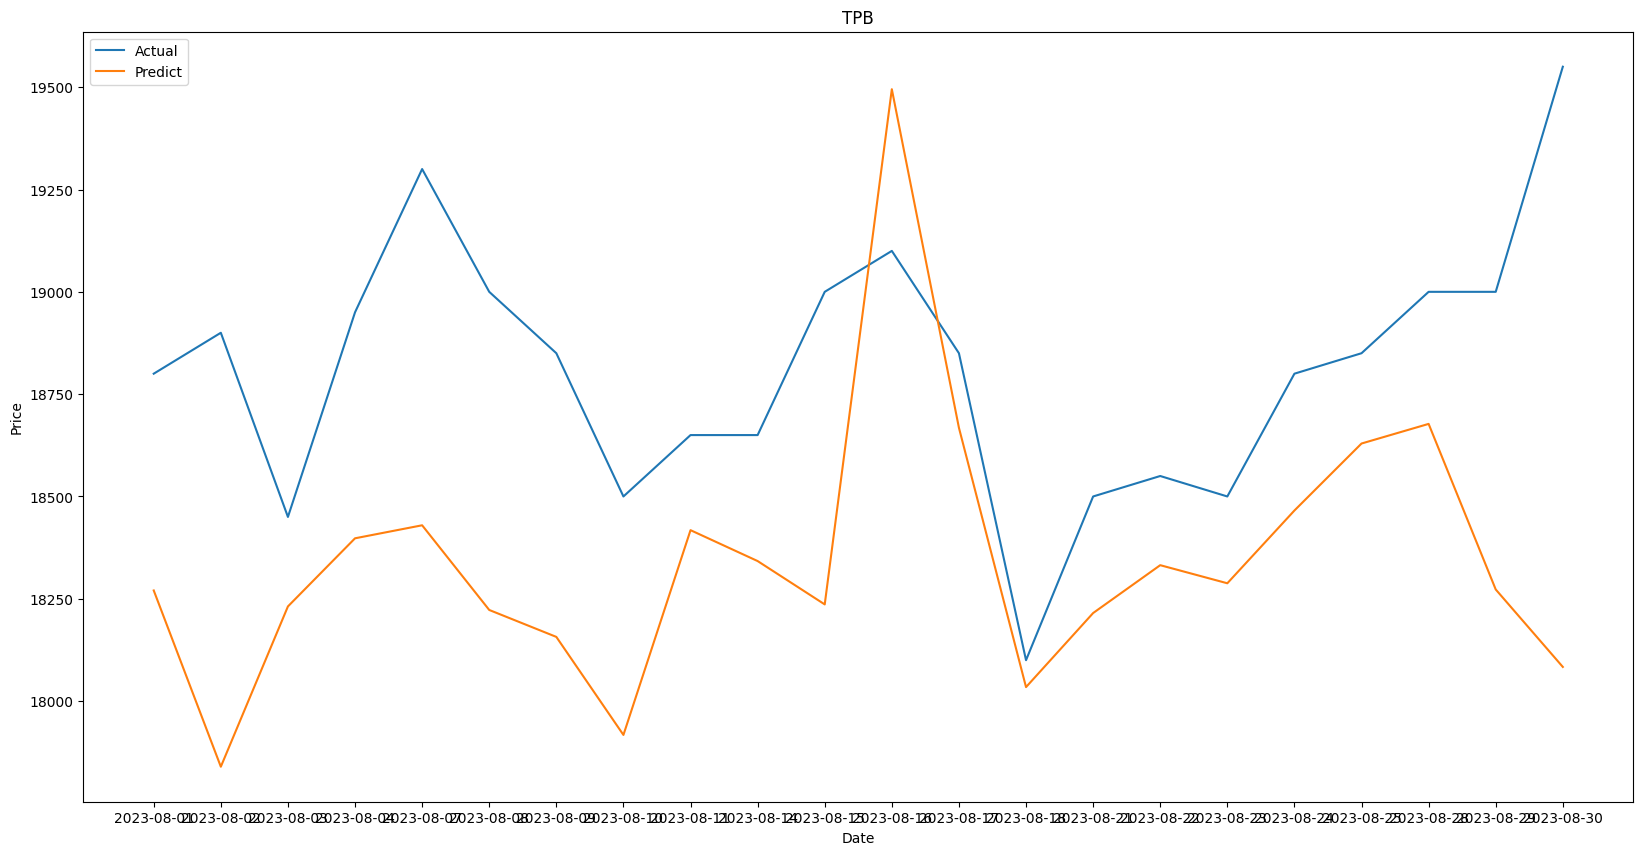

In [39]:
import matplotlib.pyplot as plt

def draw_chart(df, title):
    plt.figure(figsize=(20,10))
    plt.plot(df['date'], df['actual'], label='Actual')
    plt.plot(df['date'], df['predict'], label='Predict')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(title)
    plt.legend()
    plt.show()


def predict_chart(stock, date_start, date_end):
    df_his = stock_historical_data(stock, date_start, date_end, "1D", 'stock')
    df_his['date'] = pd.to_datetime(df_his['time']).dt.strftime('%Y-%m-%d')
    # df_his['date_formated'] = df_his['date']
    df_his = df_his[['date', 'close']]
    df_his = df_his.rename(columns={'close': 'actual'})
    df_predict = predict_by_date(date_start, date_end)
    df_merge = pd.merge(df_his, df_predict, left_on=['date'], right_on=['date'], how='inner')
    df_merge = df_merge[['date', 'actual', 'predict']]
    draw_chart(df_merge, stock)

# df_his_act = stock_historical_data('TPB', '2023-08-20', '2023-08-31', "1D", 'stock')
# print(df_his_act)

predict_chart('TPB', '2023-08-01', '2023-08-31')

In [9]:
def predict_chart(stock, date_start, date_end):
    df_his = stock_historical_data(stock, date_start, date_end, "1D", 'stock')
    df_his['date'] = pd.to_datetime(df_his['time']).dt.strftime('%Y-%m-%d')
    # df_his['date_formated'] = df_his['date']
    df_his = df_his[['date', 'close']]
    df_his = df_his.rename(columns={'close': 'actual'})
    df_predict = predict_by_date(date_start, date_end)
    df_merge = pd.merge(df_his, df_predict, left_on=['date'], right_on=['date'], how='inner')
    df_merge = df_merge[['date', 'actual', 'predict']]
    draw_chart(df_merge, stock)

Mã CP,MSB,SHB,TCB,TPB
Vốn hóa (tỷ),27300,43789,118883,41391
Giá,13650,12100,33800,18800
Số phiên tăng/giảm liên tiếp,1,1,4,1
P/E,5.7,5.5,6.7,7.0
PEG,0.4,0.4,-0.6,0.8
P/B,0.9,0.9,1.0,1.3
Cổ tức,0.0,0.0,0.0,0.0
ROE,0.178,0.183,0.158,0.198
ROA,0.022,0.014,0.026,0.018
interestMargin,0.043,0.038,0.044,0.037
